In [1]:
import os
import glob
from pathlib import Path
import pandas as pd
import json
import numpy as np
from tensorboard.backend.event_processing import event_accumulator

def get_algorithm(params_path):
    with open(params_path, "r") as f:
        params = []
        for i, l in enumerate(f.readlines()):
            params.append(l)
    # get params
    ssl = [j.split(" ")[1].strip("\n") for j in params if "ssl_task" in j][0]
    return ssl

def get_best_downstream_loss(tb_dir):
    ea = event_accumulator.EventAccumulator(tb_dir)
    ea.Reload()
    try:  
        loss = ea.Scalars('best_downstream_loss__gen_9')[-1].value
        return loss
    except:
        return None
    

exps =[f"exp6_{i}" for i in range(4)]+ [f"exp8_{i}" for i in range(4, 8)] + \
        [f"exp10_{i}" for i in range(4)] + [f"exp11_{i}" for i in range(4)]


p = Path('/home/noah/ESSL/cc_experiments/')
dirs = [str(p_i) for p_i in list(p.glob('**'))]
# print(glob.glob(f'/home/noah/ESSL/cc_experiments/*/*/', recursive = True))
csv_map = []
for e in exps: 
    e_dirs = [p_i for p_i in dirs if e == p_i.split("/")[-1]]
    csv_map_i = []
    for e_dir in e_dirs:
        model_dirs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/models"))])
        plot_dirs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/plots"))])
        tbs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/tensorboard"))])
        
        finished_exps = model_dirs.intersection(plot_dirs)
        finished_exps_tbs = finished_exps.intersection(tbs)
        if len(finished_exps) != len(finished_exps_tbs):
            continue
        for f_e in finished_exps:
            csv_map_i.append([e, os.path.basename(f_e), e_dir, f_e])
        
    csv_map+=sorted(csv_map_i, key=lambda x: str(x[1]))
    
columns = ["exp", "seed", "exp_dir", "seed_dir"]
df = pd.DataFrame(csv_map, columns=columns)
df = df.drop_duplicates(["exp", "seed"],keep= 'last')

pop_vals_df = []
for exp in df["exp"].unique():
    exp_df = df[df["exp"] == exp]
    pop_vals = []
    for _, row in exp_df.iterrows():
        outcomes_dir = os.path.join(row["seed_dir"], "outcomes.json")
        algo = get_algorithm(os.path.join(row["seed_dir"], "params.txt"))
        try:
            tb = glob.glob(os.path.join(row["seed_dir"], "tensorboard/*/*.tfevents*" ))[0]
            best_loss = get_best_downstream_loss(tb)
        except:
            best_loss = None
        with open(outcomes_dir, "r") as f:
            outcomes = json.load(f)
            pop_vals+=[[exp, algo, row["seed"], i[0], i[1], best_loss] for i in outcomes["pop_vals"]]
    pop_vals_df+=pop_vals
pop_vals_df    
df = pd.DataFrame(pop_vals_df, columns = ["exp", "algo", "seed", "generation", "fitness", "best_loss"])


See how many seeds exist for each experiment

In [2]:
seed_df = df.groupby('exp')['seed'].unique().reset_index()
print(seed_df.to_latex())


\begin{tabular}{lll}
\toprule
{} &      exp &                            seed \\
\midrule
0  &  exp10\_0 &     [0, 1, 2, 3, 4, 5, 6, 7, 8] \\
1  &  exp10\_1 &  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] \\
2  &  exp10\_2 &           [0, 1, 2, 5, 6, 7, 8] \\
3  &  exp10\_3 &     [0, 1, 2, 3, 4, 5, 6, 7, 8] \\
4  &  exp11\_0 &                       [0, 1, 2] \\
5  &  exp11\_1 &                    [0, 1, 2, 3] \\
6  &  exp11\_2 &                       [0, 1, 2] \\
7  &  exp11\_3 &                       [0, 1, 2] \\
8  &   exp6\_0 &                    [0, 1, 2, 3] \\
9  &   exp6\_1 &              [0, 1, 2, 3, 4, 5] \\
10 &   exp6\_2 &              [0, 1, 2, 3, 4, 8] \\
11 &   exp6\_3 &                    [0, 1, 2, 3] \\
12 &   exp8\_4 &        [0, 1, 2, 3, 4, 5, 6, 7] \\
13 &   exp8\_5 &        [0, 1, 2, 3, 4, 5, 6, 7] \\
14 &   exp8\_6 &        [0, 1, 2, 3, 4, 5, 6, 7] \\
15 &   exp8\_7 &        [0, 1, 2, 3, 4, 5, 6, 7] \\
\bottomrule
\end{tabular}



Visualize all seeds: We see not overly intereesting results when looking at all seeds.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

exps = ['exp6', 'exp8', 'exp10', 'exp11']
exp_titles = ['bsize=32, data=cifar10', 'bsize=256, data=cifar10', 
             'bsize=256, data=svhn', 'bsize=32, data=svhn']
# sort based on algos
algos = {algo:ind for ind, algo in enumerate(df["algo"].unique())}
# for e, title in zip(exps, exp_titles):
#     df_e = df[df["exp"].str.contains(e)]
#     x_y = sorted(list(zip(df_e["algo"], df_e["fitness"])), key=lambda x: algos[x[0]])
#     sns.boxplot(x=[x[0] for x in x_y], y=[x[1] for x in x_y])
#     plt.suptitle(title)
#     plt.show()
#     plt.clf()

Compare best seeds with manually selected best seeds:

In [4]:
max_seeds = df.groupby(["exp", "algo"])["seed", "fitness"].max()
manually_selected = glob.glob("/home/noah/ESSL/final_exps/optimization/*exp*/*")
manually_selected = [[m.split("/")[-2], m.split("/")[-1]] for m in manually_selected]
manually_selected = pd.DataFrame(manually_selected, columns = ["exp", "manually selected seed"])
merged = pd.merge(max_seeds, manually_selected, on=["exp"])
merged["selected optimal?"] = merged["seed"] == merged["manually selected seed"]
print(f"percent of manual seeds conatining best solution: {merged['selected optimal?'].sum() / len(merged)}")

percent of manual seeds conatining best solution: 0.3125


/home/noah/.conda/envs/essl/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [5]:
# sns.set_theme()
# for group, data in df.groupby(["exp", "algo"]):
#     fig, ax = plt.subplots(1,2, figsize=(15, 5))
#     sns.boxplot(data=data, x="generation", y="fitness", color='white', ax=ax[0])
#     plt.suptitle(f"{group[0]} {group[1]}")
#     ax[0].set_ylabel("Test Accuracy")
#     for i, row in data.iterrows():
#         ax[0].scatter(np.random.normal(row["generation"], 0.04), row["fitness"], alpha=0.7, color='skyblue')
#     avg_i = data.groupby("generation")['fitness'].median()
#     max_i = data.groupby("generation")['fitness'].max()
#     min_i = data.groupby("generation")['fitness'].min()
#     ax[1].plot(range(len(avg_i)), avg_i, 'b-')
#     ax[1].plot(range(len(max_i)), max_i, 'b-')
#     ax[1].plot(range(len(min_i)), min_i, 'b-')
#     ax[1].fill_between(range(len(avg_i)), min_i, max_i, color='b',
#                      alpha=0.2)
#     ax[1].set_xlabel("Generation")
#     ax[1].set_ylabel("Test Accuracy")
#     ax[1].set_xticks = (range(len(outcomes['avg'])))
#     plt.show()
#     plt.clf()

In [6]:
# ### sns.set_theme()

# ## max avg line plots for all four methods
# df_exp_generalized = df.copy()
# convert = {e:n for e, n in zip(["exp6","exp8", "exp10", "exp11"],
#                   ["bs=32, cifar10", "bs=256, cifar10",
#                   "bs=256, svhn", "bs=32, svhn"])}
# df_exp_generalized['exp'] = df_exp_generalized['exp'].apply(lambda x: x.split("_")[0])
# algos = df_exp_generalized['algo'].unique()
# colors = sns.color_palette(n_colors=len(algos))
# colors = {algo:c for algo, c in zip(algos, colors)}
# for exp, data in df_exp_generalized.groupby(["exp"]):
#     for algo, exp_data in data.groupby(["algo"]):
        
#         avg_e = exp_data.groupby("generation")["fitness"].mean().reset_index()
#         max_e = exp_data.groupby("generation")["fitness"].max().reset_index()
#         sns.lineplot(data=avg_e, x="generation", y="fitness", color=colors[algo], label=algo)
#         sns.lineplot(data=max_e, x="generation", y="fitness", color=colors[algo])
#         plt.fill_between(avg_e["generation"], avg_e["fitness"], max_e["fitness"], color=colors[algo],
#                                  alpha=0.2)
#     plt.legend()
#     plt.suptitle(convert[exp])
#     plt.show()
#     plt.clf()

visualize the best generation between all seeds

In [7]:
# ## sns.set_theme()

# ## max avg line plots for all four methods
# df_exp_generalized = df.copy()
# convert = {e:n for e, n in zip(["exp6","exp8", "exp10", "exp11"],
#                   ["bs=32, cifar10", "bs=256, cifar10",
#                   "bs=256, svhn", "bs=32, svhn"])}
# df_exp_generalized['exp'] = df_exp_generalized['exp'].apply(lambda x: x.split("_")[0])
# algos = df_exp_generalized['algo'].unique()
# colors = sns.color_palette(n_colors=len(algos))
# colors = {algo:c for algo, c in zip(algos, colors)}
# for exp, data in df_exp_generalized.groupby(["exp"]):
#     for algo, data_algo in data.groupby(["algo"]):
#         optimal_df = []
#         for gen, data_gen  in data_algo.groupby(["generation"]):
#             best_seed = data_gen.sort_values(by="fitness", ascending=False).iloc[0]["seed"]
#             data_gen = data_gen[data_gen["seed"] == best_seed]
#             optimal_df.append(data_gen)
#         optimal_df = pd.concat(optimal_df)
#         sns.boxplot(data=optimal_df, x="generation", y="fitness", color='white')
#         # plt.suptitle(f"{group[0]} {group[1]}")
#         plt.gca().set_ylabel("Test Accuracy")
#         for i, row in optimal_df.iterrows():
#             plt.scatter(np.random.normal(row["generation"], 0.04), row["fitness"], alpha=0.7, color='skyblue')
#         plt.suptitle(f"Best Generation over all seeds: {algo}, {convert[exp]} (max test acc)")
#         plt.show()
#         plt.clf()
        
        
        
        

In [8]:
# for exp, data in df_exp_generalized.groupby(["exp"]):
#     for algo, data_algo in data.groupby(["algo"]):
#         optimal_df = []
#         for gen, data_gen  in data_algo.groupby(["generation"]):
#             best_seed = data_gen.groupby(["generation", "seed"])['fitness'].mean().reset_index().max()['seed']
#             data_gen = data_gen[data_gen["seed"] == best_seed]
#             optimal_df.append(data_gen)
#         optimal_df = pd.concat(optimal_df)
#         sns.boxplot(data=optimal_df, x="generation", y="fitness", color='white')
#         plt.gca().set_ylabel("Test Accuracy")
#         for i, row in optimal_df.iterrows():
#             plt.scatter(np.random.normal(row["generation"], 0.04), row["fitness"], alpha=0.7, color='skyblue')
#         plt.suptitle(f"Best Generation over all seeds: {algo}, {convert[exp]} (avg test acc)")
#         plt.show()
#         plt.clf()

###### Compare final generation of all seeds for each method: we see here that most of them are around the same

In [9]:
# df_final = df[df["generation"] == 9]
# exps = ['exp6', 'exp8', 'exp10', 'exp11']
# exp_titles = ['bsize=32, data=cifar10', 'bsize=256, data=cifar10', 
#              'bsize=256, data=svhn', 'bsize=32, data=svhn']


# exps = ['exp6', 'exp8', 'exp10', 'exp11']
# exp_titles = ['bsize=32, data=cifar10', 'bsize=256, data=cifar10', 
#              'bsize=256, data=svhn', 'bsize=32, data=svhn']
# # sort based on algos
# algos = {algo:ind for ind, algo in enumerate(df["algo"].unique())}
# for e, title in zip(exps, exp_titles):
#     df_e = df_final[df_final["exp"].str.contains(e)]
#     x_y = sorted(list(zip(df_e["algo"], df_e["fitness"])), key=lambda x: algos[x[0]])
#     sns.boxplot(x=[x[0] for x in x_y], y=[x[1] for x in x_y])
#     plt.suptitle(title)
#     plt.show()
#     plt.clf()

# Plot the best fitness in final generation for each algorithm: this shows more intereesting results!!

with bs 256, Sim Siam is overall best, but SwAV is best for 

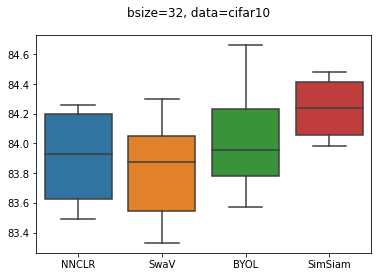

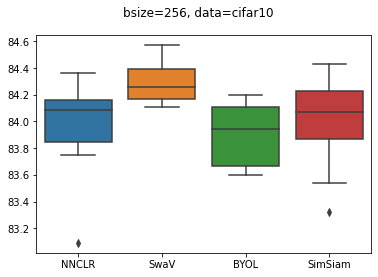

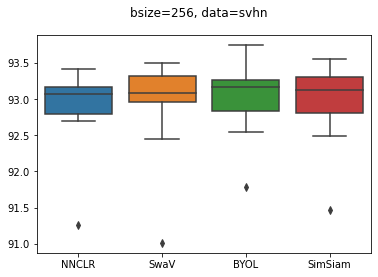

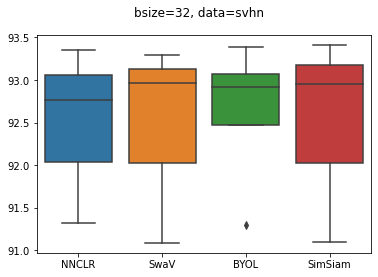

<Figure size 432x288 with 0 Axes>

In [10]:
df_final = df[df["generation"] == 9]
df_final_best = df_final.groupby(["exp", "seed", "algo"])["fitness"].max().reset_index(name='fitness').dropna()

exps = ['exp6', 'exp8', 'exp10', 'exp11']
exp_titles = ['bsize=32, data=cifar10', 'bsize=256, data=cifar10', 
             'bsize=256, data=svhn', 'bsize=32, data=svhn']

for e, title in zip(exps, exp_titles):
    df_e = df_final_best[df_final_best["exp"].str.contains(e)]
    x_y = sorted(list(zip(df_e["algo"], df_e["fitness"])), key=lambda x: algos[x[0]])
    sns.boxplot(x=[x[0] for x in x_y], y=[x[1] for x in x_y])
    plt.suptitle(title)
    plt.show()
    plt.clf()

Plot the overall best found acc average 

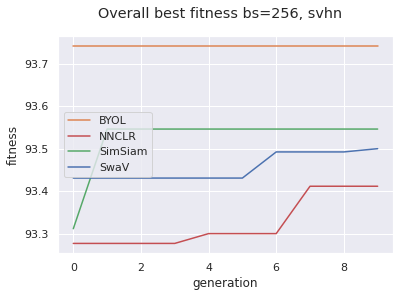

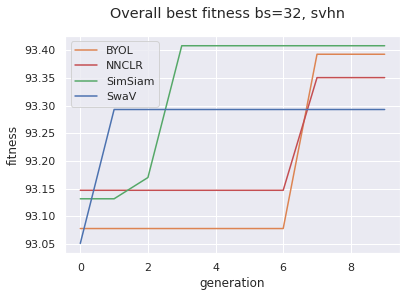

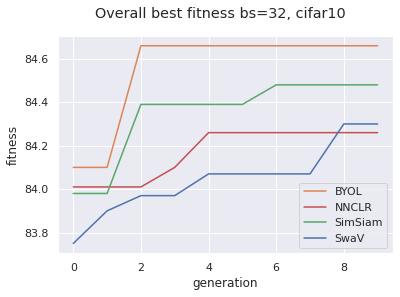

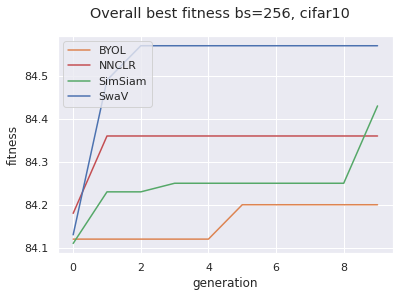

<Figure size 432x288 with 0 Axes>

In [11]:
sns.set_theme()
df_total_best = df.groupby(["exp", "seed", "algo", "generation"])["fitness"].max().reset_index(name='fitness').dropna()
df_exp_generalized = df_total_best.copy()
convert = {e:n for e, n in zip(["exp6","exp8", "exp10", "exp11"],
                  ["bs=32, cifar10", "bs=256, cifar10",
                  "bs=256, svhn", "bs=32, svhn"])}
df_exp_generalized['exp'] = df_exp_generalized['exp'].apply(lambda x: x.split("_")[0])
algos = df_exp_generalized['algo'].unique()
colors = sns.color_palette(n_colors=len(algos))
colors = {algo:c for algo, c in zip(algos, colors)}
for exp, data in df_exp_generalized.groupby(["exp"]):
    for algo, exp_data in data.groupby(["algo"]):
        
        # avg_e = exp_data.groupby("generation")["fitness"].mean().reset_index()
        max_e = exp_data.groupby("generation")["fitness"].max().reset_index()
        # sns.lineplot(data=avg_e, x="generation", y="fitness", color=colors[algo], label=algo)
        sns.lineplot(data=max_e, x="generation", y="fitness", color=colors[algo], label=algo)
        # plt.fill_between(avg_e["generation"], avg_e["fitness"], max_e["fitness"], color=colors[algo],
        #                          alpha=0.2)
    plt.legend()
    plt.suptitle("Overall best fitness " + convert[exp])
    plt.show()
    plt.clf()

Plot the average best found acc

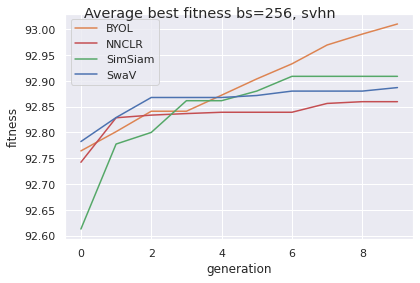

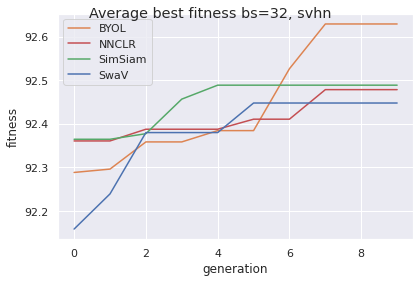

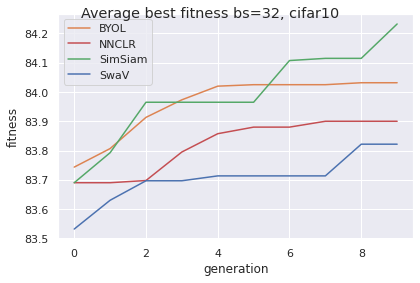

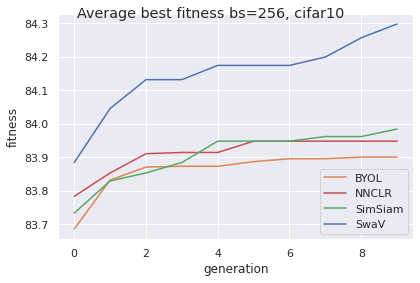

<Figure size 432x288 with 0 Axes>

In [13]:
sns.set_theme()
df_total_best = df.groupby(["exp", "seed", "algo", "generation"])["fitness"].max().reset_index(name='fitness').dropna()
df_exp_generalized = df_total_best.copy()
convert = {e:n for e, n in zip(["exp6","exp8", "exp10", "exp11"],
                  ["bs=32, cifar10", "bs=256, cifar10",
                  "bs=256, svhn", "bs=32, svhn"])}
df_exp_generalized['exp'] = df_exp_generalized['exp'].apply(lambda x: x.split("_")[0])
algos = df_exp_generalized['algo'].unique()
colors = sns.color_palette(n_colors=len(algos))
colors = {algo:c for algo, c in zip(algos, colors)}
for exp, data in df_exp_generalized.groupby(["exp"]):
    for algo, exp_data in data.groupby(["algo"]):
        
        avg_e = exp_data.groupby("generation")["fitness"].mean().reset_index()
        # max_e = exp_data.groupby("generation")["fitness"].max().reset_index()
        sns.lineplot(data=avg_e, x="generation", y="fitness", color=colors[algo], label=algo)
        # sns.lineplot(data=max_e, x="generation", y="fitness", color=colors[algo], label=algo)
        # plt.fill_between(avg_e["generation"], avg_e["fitness"], max_e["fitness"], color=colors[algo],
        #                          alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join("/home/noah/ESSL/PAPER/figures/plot_all_seeds_all_generations/best_fitness_all_seeds", "_".join(["avg_best_fit"] + convert[exp].split(", "))))
    plt.suptitle("Average best fitness " + convert[exp])
    plt.show()
    plt.clf()

Get the deltas for these results

In [14]:
sns.set_theme()
df_total_best = df.groupby(["exp", "seed", "algo", "generation"])["fitness"].max().reset_index(name='fitness').dropna()
df_exp_generalized = df_total_best.copy()
convert = {e:n for e, n in zip(["exp6","exp8", "exp10", "exp11"],
                  ["bs=32, cifar10", "bs=256, cifar10",
                  "bs=256, svhn", "bs=32, svhn"])}
df_exp_generalized['exp'] = df_exp_generalized['exp'].apply(lambda x: x.split("_")[0])
algos = df_exp_generalized['algo'].unique()
colors = sns.color_palette(n_colors=len(algos))
colors = {algo:c for algo, c in zip(algos, colors)}
avg_change = []
for exp, data in df_exp_generalized.groupby(["exp"]):
    for algo, exp_data in data.groupby(["algo"]):    
        avg_e = exp_data.groupby("generation")["fitness"].mean().reset_index()
        change = avg_e[avg_e["generation"]== 9]['fitness'].iloc[0] - avg_e[avg_e["generation"]== 0]['fitness'].iloc[0]
        avg_change.append([convert[exp], algo, change])
        
avg_d_df = pd.DataFrame(avg_change, columns=["experiment", "algorithm", "delta"]).sort_values(by="algorithm")
display(avg_d_df)
print(avg_d_df.to_latex())
net_change = avg_d_df.groupby('algorithm')['delta'].mean().reset_index()
print(net_change.to_latex())

,experiment,algorithm,delta
0,"bs=256, svhn",BYOL,0.245851
4,"bs=32, svhn",BYOL,0.340927
8,"bs=32, cifar10",BYOL,0.288333
12,"bs=256, cifar10",BYOL,0.215000
1,"bs=256, svhn",NNCLR,0.117377
5,"bs=32, svhn",NNCLR,0.117804
9,"bs=32, cifar10",NNCLR,0.210000
13,"bs=256, cifar10",NNCLR,0.165000
2,"bs=256, svhn",SimSiam,0.295790
6,"bs=32, svhn",SimSiam,0.124206


\begin{tabular}{lllr}
\toprule
{} &       experiment & algorithm &     delta \\
\midrule
0  &     bs=256, svhn &      BYOL &  0.245851 \\
4  &      bs=32, svhn &      BYOL &  0.340927 \\
8  &   bs=32, cifar10 &      BYOL &  0.288333 \\
12 &  bs=256, cifar10 &      BYOL &  0.215000 \\
1  &     bs=256, svhn &     NNCLR &  0.117377 \\
5  &      bs=32, svhn &     NNCLR &  0.117804 \\
9  &   bs=32, cifar10 &     NNCLR &  0.210000 \\
13 &  bs=256, cifar10 &     NNCLR &  0.165000 \\
2  &     bs=256, svhn &   SimSiam &  0.295790 \\
6  &      bs=32, svhn &   SimSiam &  0.124206 \\
10 &   bs=32, cifar10 &   SimSiam &  0.542500 \\
14 &  bs=256, cifar10 &   SimSiam &  0.251250 \\
3  &     bs=256, svhn &      SwaV &  0.104572 \\
7  &      bs=32, svhn &      SwaV &  0.289387 \\
11 &   bs=32, cifar10 &      SwaV &  0.290000 \\
15 &  bs=256, cifar10 &      SwaV &  0.413750 \\
\bottomrule
\end{tabular}

\begin{tabular}{llr}
\toprule
{} & algorithm &     delta \\
\midrule
0 &      BYOL &  0.272528 \\
1 

In [ ]:
# df_total_best = df.groupby(["exp", "seed", "algo", "generation"])["fitness"].max().reset_index(name='fitness').dropna()
# df_exp_generalized = df_total_best.copy()
# convert = {e:n for e, n in zip(["exp6","exp8", "exp10", "exp11"],
#                   ["bs=32, cifar10", "bs=256, cifar10",
#                   "bs=256, svhn", "bs=32, svhn"])}
# df_exp_generalized['exp'] = df_exp_generalized['exp'].apply(lambda x: x.split("_")[0])
# algos = df_exp_generalized['algo'].unique()
# colors = sns.color_palette(n_colors=len(algos))
# colors = {algo:c for algo, c in zip(algos, colors)}
# for exp, data in df_exp_generalized.groupby(["exp"]):
#     for algo, exp_data in data.groupby(["algo"]):
        
#         avg_e = exp_data.groupby("generation")["fitness"].mean().reset_index()
#         max_e = exp_data.groupby("generation")["fitness"].max().reset_index()
#         sns.lineplot(data=avg_e, x="generation", y="fitness", color=colors[algo], label=algo)
#         sns.lineplot(data=max_e, x="generation", y="fitness", color=colors[algo])
#         plt.fill_between(avg_e["generation"], avg_e["fitness"], max_e["fitness"], color=colors[algo],
#                                  alpha=0.2)
#     plt.legend()
#     plt.suptitle(convert[exp])
#     plt.show()
#     plt.clf()

Compare the generation with the best test acc for each method

In [ ]:
# df_best_gen = df.groupby(["exp", "algo"]).max().reset_index()

# exps = ['exp6', 'exp8', 'exp10', 'exp11']
# exp_titles = ['bsize=32, data=cifar10', 'bsize=256, data=cifar10', 
#              'bsize=256, data=svhn', 'bsize=32, data=svhn']

# for e, title in zip(exps, exp_titles):
#     df_e = df[df["exp"].str.contains(e)]
#     df_best_gen_e = df_best_gen[df_best_gen["exp"].str.contains(e)][["exp", "algo", "seed", "generation"]]
#     bool_df = ((df_e == df_best_gen_e.iloc[0]).sum(axis=1) == 4).astype(int)
#     for _, row in df_best_gen_e.iterrows():
#         bool_df += ((df_e == row).sum(axis=1) == 4).astype(int)
#     bool_df = bool_df.astype(bool)
#     df_e = df_e[bool_df]
#     x_y = sorted(list(zip(df_e["algo"], df_e["fitness"])), key=lambda x: algos[x[0]])
#     sns.boxplot(x=[x[0] for x in x_y], y=[x[1] for x in x_y])
#     plt.suptitle(title)
#     plt.show()
#     plt.clf()

In [ ]:
# from IPython.core.display import display, HTML
# enc= {k:v for k, v in zip(['exp6', 'exp8', 'exp10', 'exp11'], 
#                           ['bsize=32, data=cifar10', 'bsize=256, data=cifar10', 
#                              'bsize=256, data=svhn', 'bsize=32, data=svhn'])}

# rev_enc = {v:k for k,v in enc.items()}

# df_table = df_best_gen[['exp', 'algo','fitness', 'best_loss']]
# df_table.columns = ['exp', 'algo', 'test acc', 'test loss']
# df_table['exp'] = df_table['exp'].apply(lambda x: enc[x.split('_')[0]])
# for exp in df_table["exp"].unique():
#     display(HTML(df_table[df_table["exp"]== exp].to_html()))
# # latex
# for exp in df_table["exp"].unique():
#     print(df_table[df_table["exp"]== exp].drop(columns=["exp"]).to_latex(caption=f"best test acc, {exp}", label="bta_"+rev_enc[exp]))
# df_table.to_csv("/home/noah/ESSL/cc_experiments/results/best_results_so.csv")
# best_vals = []
# for e in df_table["exp"].unique():
#     best_vals.append(df_table[df_table['exp'] == e].sort_values(by='test acc', ascending=False).iloc[0])
# df_table = pd.DataFrame(best_vals)

# # df_table.to_csv("/home/noah/ESSL/cc_experiments/results/so_best.csv")
# # df["algo"].value_counts()
# # df_table.to_csv("/home/noah/ESSL/cc_experiments/results/so_best.csv")

In [ ]:
# df_best_gen_seed = df.groupby(["exp", "algo", "seed"]).max().reset_index()
# df_best_gen_seed = df_best_gen_seed.groupby(["exp", "algo"]).mean().reset_index()

# df_table = df_best_gen_seed[['exp', 'algo','fitness', 'best_loss']]
# df_table.columns = ['exp', 'algo', 'avg test acc', 'avg test loss']
# df_table['exp'] = df_table['exp'].apply(lambda x: enc[x.split('_')[0]])
# for exp in df_table["exp"].unique():
#     display(HTML(df_table[df_table["exp"]== exp].to_html()))

# # latex
# rev_enc = {v:k for k,v in enc.items()}
# for exp in df_table["exp"].unique():
#     print(df_table[df_table["exp"]== exp].drop(columns=["exp"]).to_latex(caption=f"avg best test acc, {exp}", label="abta_"+rev_enc[exp]))    
# # df_table.to_csv("/home/noah/ESSL/cc_experiments/results/so_avg_best.csv")